In [1]:
import networkx as nx
import numpy as np
from datetime import datetime
import mysql.connector
import matplotlib.pyplot as plt
import utils

from gem.embedding.static_graph_embedding import StaticGraphEmbedding
from gem.utils import graph_util, plot_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr

from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding

import n2v as N2V
import Tweet as tweet
from gensim.models import Word2Vec

from time import time

C:\Users\Helin\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def read_data_from_database(script):
    mydb = mysql.connector.connect(
        user = "root",
        password = "D12345",
        host = "localhost",
        database = "tweetermysql_2018-07-30"
    )

    my_cursor = mydb.cursor()

    my_cursor.execute(script)

    my_result = my_cursor.fetchall()
    
    data = list()
    
    for item in my_result:
        u, m_data, date, section = item
        t = tweet.Tweet(u,section,m_data,datetime.strptime(date,'%Y-%m-%d'))
        data.append(t)
    
    return data

In [3]:
def create_graph(tweets):
    G1 = nx.Graph()

    for tweet in tweets:
        G1.add_node(tweet.user)
        tweetFormat = str(tweet.Id)
        G1.add_edge(tweet.user,tweetFormat,weight=1.0)
        #G1.add_edge(YEAR_TAG,tweet.date.year,weight=15.0)
        #G.add_edge(tweet.date.year,YEAR_TAG,weight=1.0)
        for word in tweet.text.split():
            G1.add_edge(word,tweetFormat,weight=1.0)
            #print(word)
        monthFormat = "{month}.{year}".format(month=tweet.date.month,year=tweet.date.year)
        
        G1.add_edge(str(tweet.date.year),monthFormat,weight=1.0)
        G.add_edge(monthFormat,str(tweet.date.year),weight=1.0)
        
        dayFormat = "{day}.{month}.{year}".format(day=tweet.date.day,month=tweet.date.month,year=tweet.date.year)
        G1.add_edge(monthFormat,dayFormat,weight=1.0)
        G1.add_edge(dayFormat,tweetFormat,weight=1.0)
    return G1

In [4]:
tweets = read_data_from_database(' select ID, MetaData, Date, Section from news_2017_01 limit 2')
#tweets = sampleTweets()
G = nx.Graph()
G = create_graph(tweets)
for edge in G.edges():
	G[edge[0]][edge[1]]['weight'] = 1

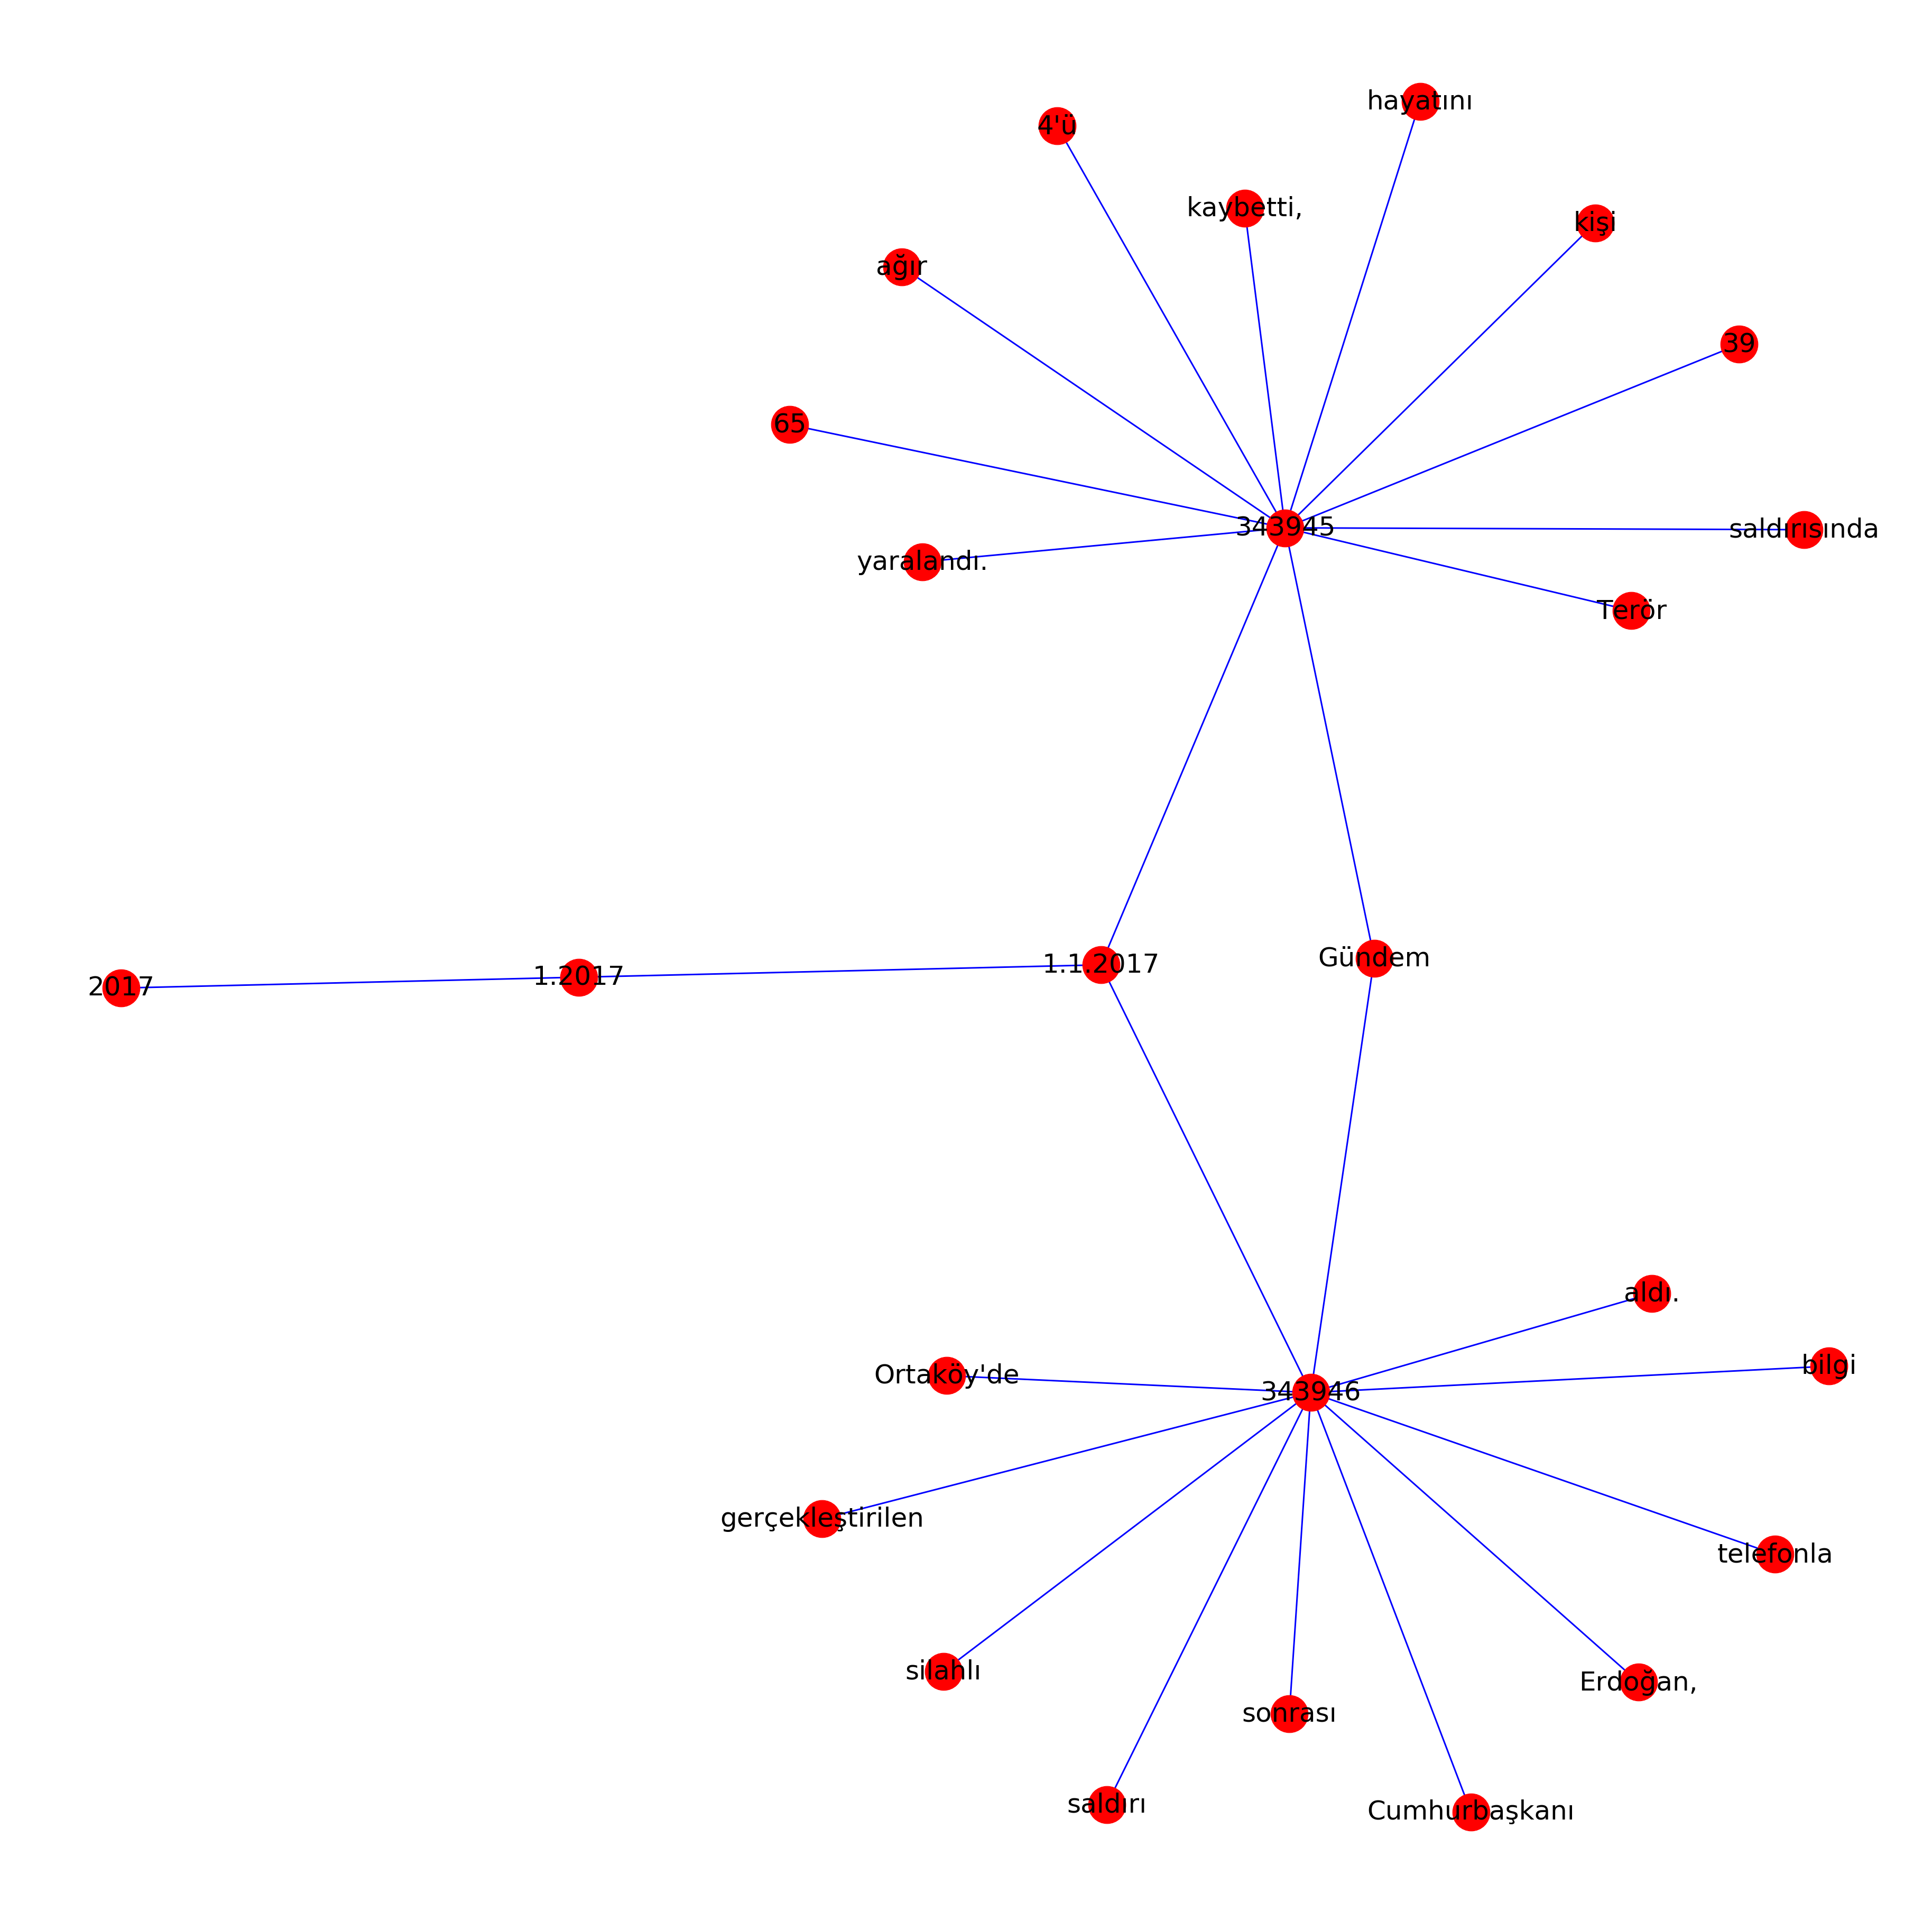

In [5]:
plt.figure(1, figsize=(50,50))
#nx.draw(G,with_labels=True,pos=nx.spring_layout(G),nodecolor='r', edge_color='b')
nx.draw_kamada_kawai(G,node_size=5000,font_size=50,with_labels=True, width=3, edge_color="b", arrows=True, arrowsize=30)
plt.show()

In [8]:
models = []
models.append(N2V.Graph(G, is_directed=False, p=1.0, q=0.1))
models.append(GraphFactorization(d=2, max_iter=50000, eta=1 * 10**-4, regu=0.1))
models.append(HOPE(d=4, beta=0.01))
models.append(LaplacianEigenmaps(d=2))
models.append(LocallyLinearEmbedding(d=2))


Num nodes: 26, num edges: 26
Node2Vec:
	Training time: 2.242774


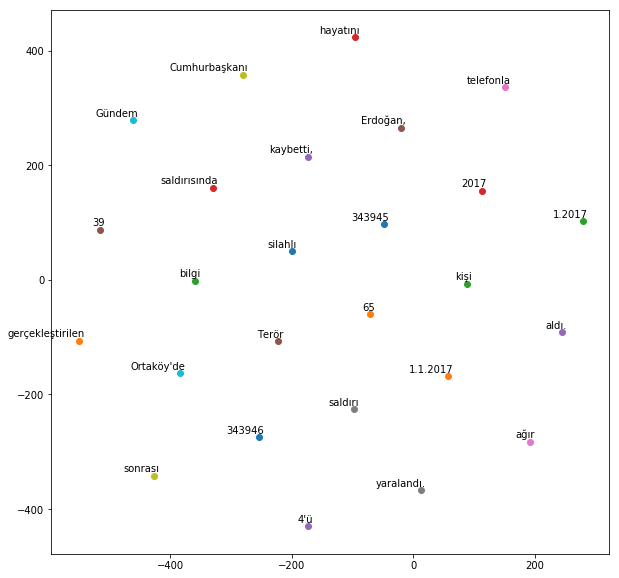

Num nodes: 26, num edges: 26
		Iter id: 0, Objective: 0.000528375, f1: 0, f2: 0.000528375
		Iter id: 10000, Objective: 0.000528375, f1: 0, f2: 0.000528375
		Iter id: 20000, Objective: 0.000528375, f1: 0, f2: 0.000528375
		Iter id: 30000, Objective: 0.000528375, f1: 0, f2: 0.000528375
		Iter id: 40000, Objective: 0.000528375, f1: 0, f2: 0.000528375
graph_factor_sgd:
	Training time: 0.993234


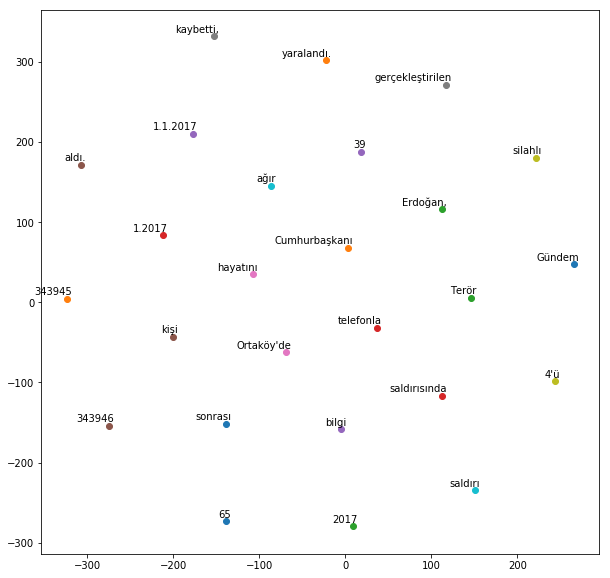

Num nodes: 26, num edges: 26
SVD error (low rank): 0.048717
hope_gsvd:
	Training time: 0.008549


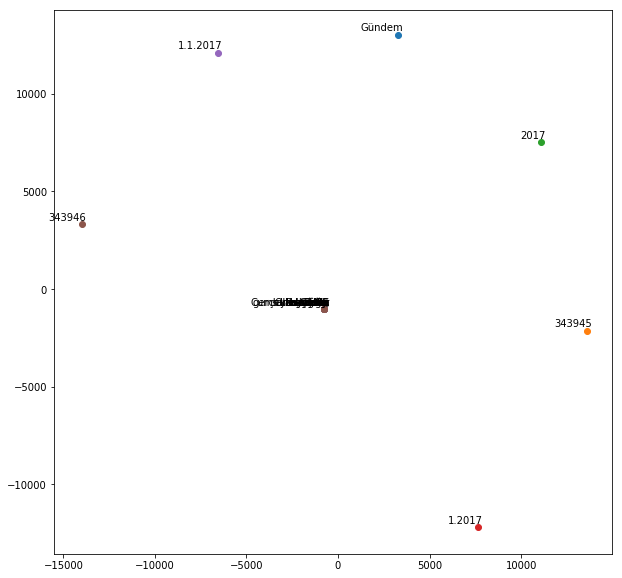

Num nodes: 26, num edges: 26
Laplacian matrix recon. error (low rank): 5.558469
lap_eigmap_svd:
	Training time: 0.000000


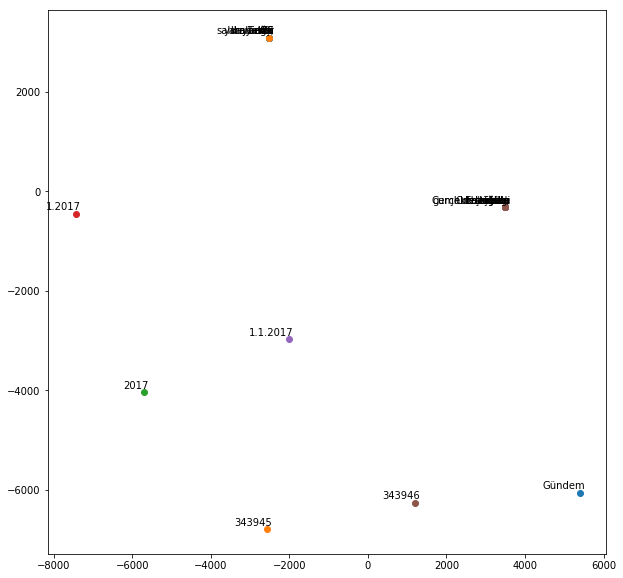

Num nodes: 26, num edges: 26
lle_svd:
	Training time: 0.015623


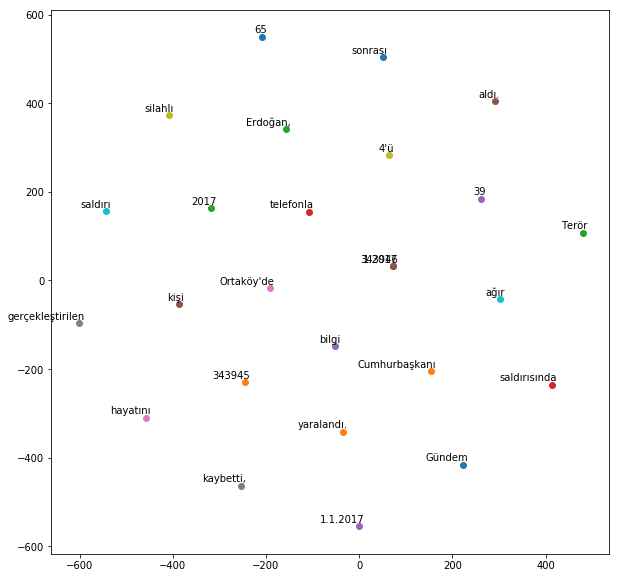

In [9]:
for embedding in models:
    print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
    t1 = time()
    # Learn embedding - accepts a networkx graph or file with edge list
    Y, t = embedding.learn_embedding(graph=G, edge_f=None, is_weighted=False, no_python=False)
    print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
    
    if embedding._method_name == 'Node2Vec':
        utils.draw_tsne(Y,fig_size=(10,10))
    else:
        utils.draw_tsne2(Y,fig_size=(10,10))
        #print(Y)